In [1]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for filenames
pref='loc_lat_'

In [2]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm



Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)

<module 'LMR_lite_utils' from '/Users/dan/Desktop/LMR_py3/LMR_lite_utils.py'>

In [4]:
# load proxies
lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
cfile = './configs/config.yml.nullspace.'+lmr_names[0]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

prox_manager = LMRlite.load_proxies(cfg)
numprox = len(prox_manager.all_proxies)

Checking configuration ... 
OK!
                                 Bivalve_d18O :     1
               Corals and Sclerosponges_Rates :     8
                Corals and Sclerosponges_SrCa :    25
                Corals and Sclerosponges_d18O :    59
                        Ice Cores_MeltFeature :     1
                               Ice Cores_d18O :    28
                                 Ice Cores_dD :     7
                              Lake Cores_Misc :     2
                             Lake Cores_Varve :     5
                       Tree Rings_WidthPages2 :   347
                       Tree Rings_WoodDensity :    59
                                        TOTAL :   542
-----------------------------------------------------
completed in 3.2142059803009033 seconds
-----------------------------------------------------


In [5]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ad = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887 7.239956964122407 -0.007491004016465484 0.8339612765545283
0


In [6]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords


In [11]:
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

def process_input(LOCRAD):
    NENS = grid.nens
    SNR = 0.4

    # Initialize array of dictionaries containing the different comparisons
    cdd = []

    # Loop over prior files
    for ii in np.arange(len(lmr_names)):

        # Load the config file corresponding to the iith prior
        cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        # Compute effective observations
        vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

        # change the localization radius in the config file
        cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
        cfg_new = LMR_config.Config(**cfg_params)

        # Loop over truth files
        for jj in np.arange(len(lmr_names)):

            # Use a precomputed interpolated version of the truth
            vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

            fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

            # Loop over ensemble members
            for kk in np.arange(NENS):
                if LOCRAD==0.:
                    f,Xap,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
                else:
                    f,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

                fp[:,kk] = f

            # Store information in a dictionary for this prior-truth pair
            c = {}
            c['locrad']     = LOCRAD
            c['snr']        = SNR
            c['prior_name'] = ad[ii]['name']
            c['truth_name'] = ad[jj]['name']
            c['pind']       = ii
            c['tind']       = jj
            c['recon']      = fp
            c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

            # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
            # for the choices of LOCRAD and SNR
            cdd.append(c)

    # Save all prior-truth pairs for these choices of LOCRAD and SNR
    print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
    np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_'  +pref + str(LOCRAD)+ '_snr_' + str(SNR),cdd)


In [12]:
# Run in parallel
LOCRADs = [0.,50000.,35000.,25000.,10000.,5000.,2000.]

from joblib import Parallel, delayed
import multiprocessing
#num_cores = multiprocessing.cpu_count()
nj = len(LOCRADs)
Parallel(n_jobs=nj)(delayed(process_input)(LOCRADs[i]) for i in np.arange(nj))

[None, None, None, None, None, None, None]

In [17]:
# Zonal means plot
#LOCRAD=10000
import pandas as pd

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
#LOCRADs = ['2000.0', '5000.0', '10000.0', '25000.0']
LOCRADs = ['0.0','50000.0','35000.0','25000.0','10000.0','5000.0','2000.0']
lat = ad[0]['grid'].lat

#gm = np.empty([9,len(LOCRADs)])

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' +pref+ LOCRAD + '_snr_' + SNR + '.npy')

    for jj in np.arange(len(cdd4)):
      
        #gm[jj,ii] = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse'])/np.sum(np.cos(np.deg2rad(lat)))
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse'])/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




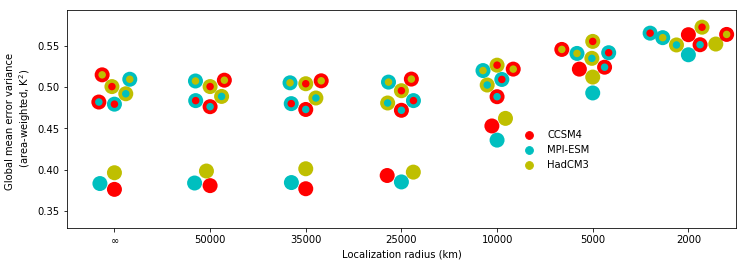

In [18]:
#for ii in np.arange(9):
#    plt.scatter(np.arange(len(LOCRADs)),gm[ii,:],marker='o', facecolors='none',edgecolors='k')


#plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000'])
#plt.xlabel('Localization radius (km)')
#plt.ylabel('Global mean error variance (area-weighted)')
#plt.show()

import seaborn as sns

#sns.set(style='ticks', context='talk')
#iris = sns.load_dataset('iris')

#pd.DataFrame(gm)
si = 15
fig = plt.figure(figsize=(12,4))
sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','50000','35000','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.67, .47), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD' +pref+'.pdf')


In [ ]:
def mapplot(map,grid):
    fig = plt.figure(figsize=(8,4))
    r2w, wrap_lon = cutil.add_cyclic_point(map, coord=grid.lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='RdBu_r',vmin=-1,vmax=1)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#    ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
    sm = plt.cm.ScalarMappable(cmap='RdBu_r')#,norm=plt.Normalize(0,1))
    sm._A = []
    plt.colorbar(sm,ax=ax)
    
    return ax


